# Actividad 1: Predicción de Fuga con Regresión Logística

**Integrante:**

- Felipe Santiago Goicolea Guerra

**Universidad de las Américas, Magíster en Data Science 2025**

**Asignatura:** Machine Learning II  

---
## Contexto
El objetivo es predecir la fuga de clientes (Churn) utilizando Regresión Logística, comparando modelos básicos, polinomiales y regularizados. Se evaluará el rendimiento mediante métricas robustas (ROC, PR-AUC, F1) y Validación Cruzada.

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
np.random.seed(42)

## Paso 1: Preprocesamiento y Exploración de Datos

En esta etapa cargamos los datos, tratamos valores nulos (específicamente en `TotalCharges`), eliminamos columnas innecesarias (`customerID`) y preparamos los datos para el modelado.

# Diccionario de Datos: Telco Customer Churn

Este dataset contiene información sobre clientes de una empresa de telecomunicaciones. El objetivo principal suele ser predecir el **Churn** (abandono), es decir, clientes que cancelan el servicio.

### Variable Objetivo (Target)
* **`Churn`**: Indica si el cliente ha cancelado el servicio en el último mes (`Yes` o `No`).

### Información Demográfica
| Variable | Descripción |
| :--- | :--- |
| `customerID` | Identificador único para cada cliente. |
| `gender` | Género del cliente (Male/Female). |
| `SeniorCitizen` | Indica si el cliente es una persona mayor (1 = Sí, 0 = No). |
| `Partner` | Indica si el cliente tiene pareja (Yes/No). |
| `Dependents` | Indica si el cliente tiene dependientes económicos (Yes/No). |

### Información de la Cuenta y Cargos
| Variable | Descripción |
| :--- | :--- |
| `tenure` | Cantidad de meses que el cliente ha permanecido en la compañía. |
| `Contract` | Tipo de contrato del cliente (Month-to-month, One year, Two year). |
| `PaperlessBilling` | Si el cliente utiliza facturación electrónica sin papel (Yes/No). |
| `PaymentMethod` | Método de pago (Electronic check, Mailed check, Bank transfer, Credit card). |
| `MonthlyCharges` | Monto cargado al cliente mensualmente. |
| `TotalCharges` | Monto total cargado al cliente durante toda su estancia. |

### 📡 Servicios Contratados
| Variable | Descripción |
| :--- | :--- |
| `PhoneService` | Si el cliente tiene servicio telefónico (Yes/No). |
| `MultipleLines` | Si el cliente tiene múltiples líneas (Yes, No, No phone service). |
| `InternetService` | Proveedor de servicios de internet (DSL, Fiber optic, No). |
| `OnlineSecurity` | Si tiene servicio de seguridad online (Yes, No, No internet service). |
| `OnlineBackup` | Si tiene servicio de copia de seguridad online. |
| `DeviceProtection` | Si tiene seguro de protección del dispositivo. |
| `TechSupport` | Si tiene soporte técnico contratado. |
| `StreamingTV` | Si tiene servicio de TV por streaming. |
| `StreamingMovies` | Si tiene servicio de películas por streaming. |

In [10]:
# Cargar datos
df = pd.read_csv('data-churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [11]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [12]:
print("Tamaño del dataset:", df.shape)

print(df["Churn"].value_counts(normalize=True).rename("proporción"))

df.describe(include="all").transpose().head(20)

Tamaño del dataset: (7043, 21)
Churn
0    0.73463
1    0.26537
Name: proporción, dtype: float64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
numeric_features = [
    "MonthlyCharges",
    "TotalCharges",
    "tenure"
]

categorical_features = [
    "Contract",
    "InternetService",
    "PaymentMethod",
    "PhoneService"
]

X = df[numeric_features + categorical_features]
y = df["Churn"]

In [14]:
for col in numeric_features:
    X[col] = pd.to_numeric(X[col], errors="coerce")

/var/folders/ww/3ngzmdjx4fg2hcj_zjm649b80000gn/T/ipykernel_1506/27114591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors="coerce")


In [15]:
X = X.dropna()
y = y[X.index]

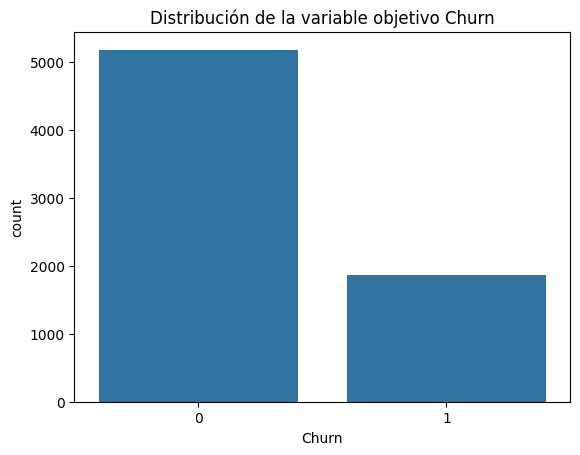

In [16]:
# dristribucion de la variable objetivo
sns.countplot(x='Churn', data=df)
plt.title('Distribución de la variable objetivo Churn')
plt.show()

La gráfica muestra la distribución de la variable objetivo Churn, con dos clases:
- Clase 0 (No churn): más de 5000 casos.
- Clase 1 (Sí churn): menos de 2000 casos.

Esto indica un desbalance de clases, donde la mayoría de los clientes no se han ido.

Este tipo de desbalance puede afectar el rendimiento de modelos de clasificación como la regresión logística, ya que tienden a favorecer la clase mayoritaria.

# Pipeline de Preprocesamiento
Definimos un `ColumnTransformer` que:
1. Escala las variables numéricas (StandardScaler).
2. Aplica One-Hot Encoding a las categóricas.

In [17]:
numeric_transformer_base = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_base = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_base, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

## Funciones Auxiliares de Evaluación
Definimos una función para realizar la validación cruzada y graficar las curvas ROC y PR, como solicita la actividad.

In [18]:
def evaluate_model_cv(model, X, y, cv_splits=5):
    """
    Ejecuta k-fold CV estratificada y:
    - Ajusta el modelo en cada fold
    - Acumula predicciones y probabilidades
    - Muestra matriz de confusión, reporte, ROC, PR
    """
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []
    y_proba_all = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_proba_all.extend(y_proba)

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_proba_all = np.array(y_proba_all)

    # Matriz de confusión
    cm = confusion_matrix(y_true_all, y_pred_all)
    print("Matriz de confusión global (todos los folds):")
    print(cm)

    # Reporte de clasificación
    print("Reporte de clasificación:")
    print(classification_report(y_true_all, y_pred_all, digits=3))

    # ROC
    fpr, tpr, _ = roc_curve(y_true_all, y_proba_all)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("Curva ROC (CV global)")
    plt.legend()
    plt.show()

    # Precision–Recall
    precision, recall, _ = precision_recall_curve(y_true_all, y_proba_all)
    pr_auc = average_precision_score(y_true_all, y_proba_all)

    plt.figure()
    plt.step(recall, precision, where="post", label=f"PR (AP = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision–Recall (CV global)")
    plt.legend()
    plt.show()

    print(f"AUC-ROC global: {roc_auc:.3f}")
    print(f"PR-AUC (Average Precision) global: {pr_auc:.3f}")

    return {
        "cm": cm,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }

In [19]:
X

,MonthlyCharges,TotalCharges,tenure,Contract,InternetService,PaymentMethod,PhoneService
0,29.85,29.85,1,Month-to-month,DSL,Electronic check,No
1,56.95,1889.50,34,One year,DSL,Mailed check,Yes
2,53.85,108.15,2,Month-to-month,DSL,Mailed check,Yes
3,42.30,1840.75,45,One year,DSL,Bank transfer (automatic),No
4,70.70,151.65,2,Month-to-month,Fiber optic,Electronic check,Yes
...,...,...,...,...,...,...,...
7038,84.80,1990.50,24,One year,DSL,Mailed check,Yes
7039,103.20,7362.90,72,One year,Fiber optic,Credit card (automatic),Yes
7040,29.60,346.45,11,Month-to-month,DSL,Electronic check,No
7041,74.40,306.60,4,Month-to-month,Fiber optic,Mailed check,Yes


## Paso 2: Modelo Básico (Regresión Logística)

Entrenamos un modelo de Regresión Logística básico y evaluamos su rendimiento utilizando las funciones definidas anteriormente.

Matriz de confusión global (todos los folds):
[[4610  553]
 [ 885  984]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.839     0.893     0.865      5163
           1      0.640     0.526     0.578      1869

    accuracy                          0.796      7032
   macro avg      0.740     0.710     0.721      7032
weighted avg      0.786     0.796     0.789      7032



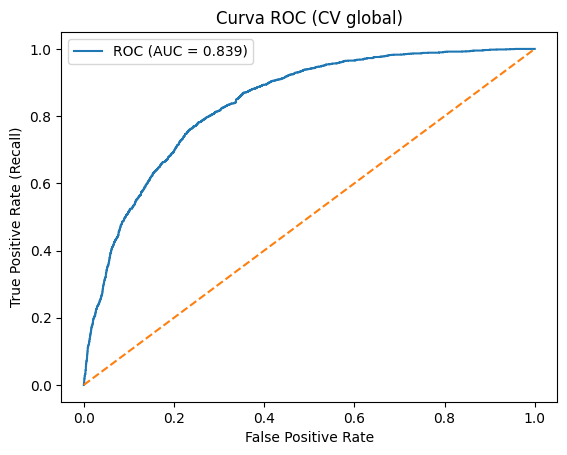

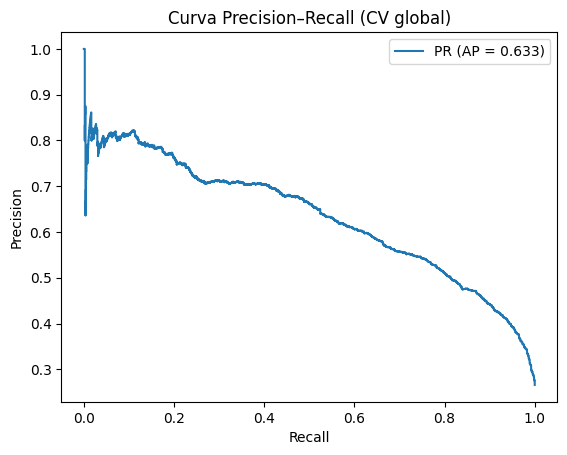

AUC-ROC global: 0.839
PR-AUC (Average Precision) global: 0.633


In [20]:
log_reg_base = Pipeline(steps=[
    ("preprocess", preprocessor_base),
    ("clf", LogisticRegression(
        penalty="l2",   # C grande ≈ sin regularización fuerte
        C=1e6,
        solver="lbfgs",
        max_iter=1000
    ))
])


results_base = evaluate_model_cv(log_reg_base, X, y, cv_splits=5)

## Paso 3: Transformaciones Polinomiales
Añadimos complejidad al modelo generando características polinomiales (grado 2) solo para las variables numéricas, permitiendo capturar relaciones no lineales e interacciones.

Matriz de confusión global (todos los folds):
[[4705  458]
 [ 972  897]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.829     0.911     0.868      5163
           1      0.662     0.480     0.556      1869

    accuracy                          0.797      7032
   macro avg      0.745     0.696     0.712      7032
weighted avg      0.784     0.797     0.785      7032



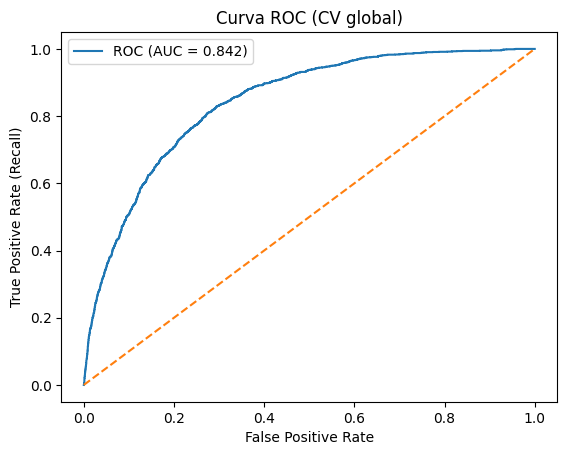

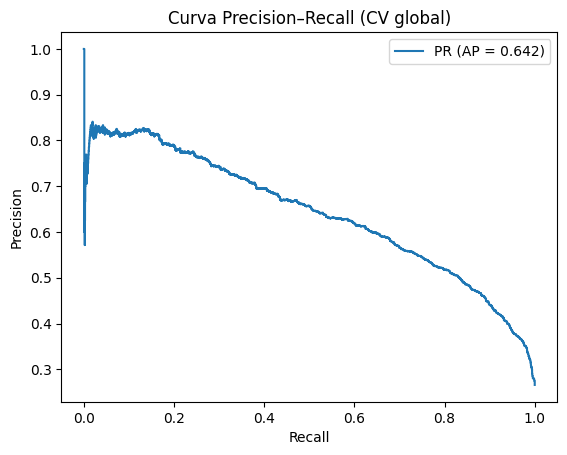

AUC-ROC global: 0.842
PR-AUC (Average Precision) global: 0.642


In [21]:
numeric_transformer_poly = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=4, include_bias=False))
])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_poly, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

log_reg_poly = Pipeline(steps=[
    ("preprocess", preprocessor_poly),
    ("clf", LogisticRegression(
        penalty="l2",
        C=1e6,
        solver="lbfgs",
        max_iter=1000
    ))
])

results_poly = evaluate_model_cv(log_reg_poly, X, y, cv_splits=5)

## Paso 4: Regularización y Grid Search
Al aumentar la dimensionalidad con polinomios, el riesgo de sobreajuste crece. Aplicamos regularización (L1 y L2) y buscamos el mejor hiperparámetro `C`.

In [22]:
base_pipeline_poly = Pipeline(steps=[
    ("preprocess", preprocessor_poly),
    ("clf", LogisticRegression(max_iter=1000))
])

In [23]:
param_grid_l2 = {
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"],
    "clf__C": [0.01, 0.1, 1.0, 10.0]
}

grid_l2 = GridSearchCV(
    base_pipeline_poly,
    param_grid_l2,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="average_precision",  # PR-AUC
    n_jobs=-1
)

grid_l2.fit(X, y)

print("Mejores hiperparámetros (L2):", grid_l2.best_params_)
print("Mejor PR-AUC medio (L2):", grid_l2.best_score_)

best_model_l2 = grid_l2.best_estimator_

Mejores hiperparámetros (L2): {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Mejor PR-AUC medio (L2): 0.6467260859470142


In [24]:
param_grid_l1 = {
    "clf__penalty": ["l1"],
    "clf__solver": ["liblinear"],
    "clf__C": [0.01, 0.1, 1.0, 10.0]
}

grid_l1 = GridSearchCV(
    base_pipeline_poly,
    param_grid_l1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="average_precision",
    n_jobs=-1
)

grid_l1.fit(X, y)

print("Mejores hiperparámetros (L1):", grid_l1.best_params_)
print("Mejor PR-AUC medio (L1):", grid_l1.best_score_)

best_model_l1 = grid_l1.best_estimator_

Mejores hiperparámetros (L1): {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Mejor PR-AUC medio (L1): 0.6463935104171533


Matriz de confusión global (todos los folds):
[[4718  445]
 [ 969  900]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.830     0.914     0.870      5163
           1      0.669     0.482     0.560      1869

    accuracy                          0.799      7032
   macro avg      0.749     0.698     0.715      7032
weighted avg      0.787     0.799     0.787      7032



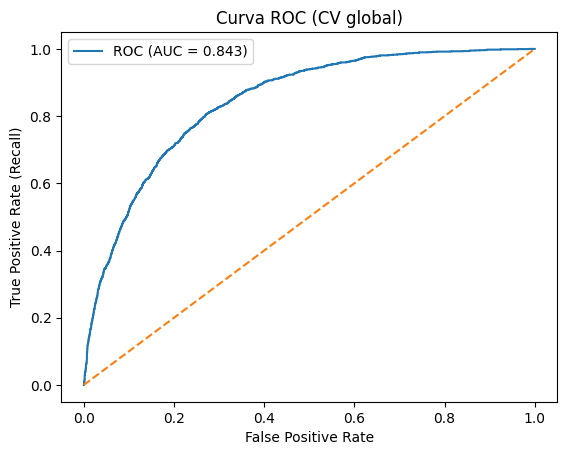

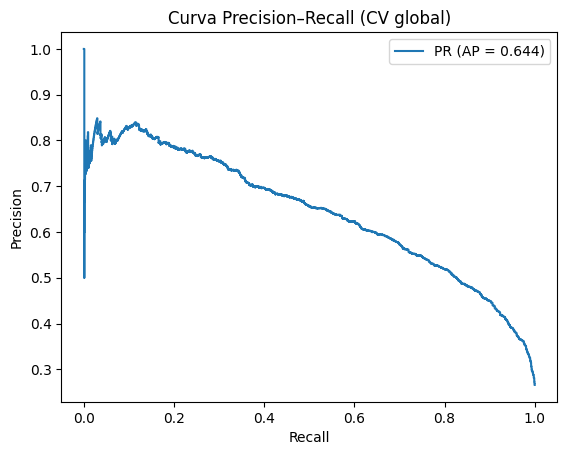

AUC-ROC global: 0.843
PR-AUC (Average Precision) global: 0.644
Matriz de confusión global (todos los folds):
[[4707  456]
 [ 958  911]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.831     0.912     0.869      5163
           1      0.666     0.487     0.563      1869

    accuracy                          0.799      7032
   macro avg      0.749     0.700     0.716      7032
weighted avg      0.787     0.799     0.788      7032



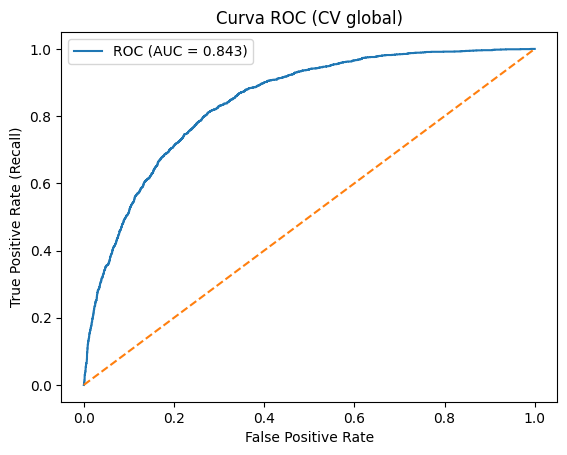

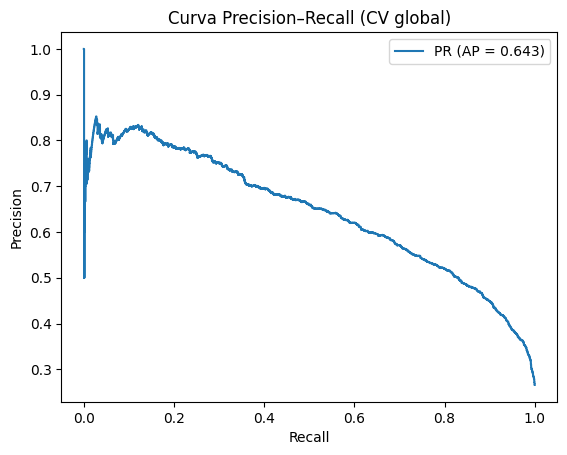

AUC-ROC global: 0.843
PR-AUC (Average Precision) global: 0.643


In [25]:
results_l2 = evaluate_model_cv(best_model_l2, X, y, cv_splits=5)

results_l1 = evaluate_model_cv(best_model_l1, X, y, cv_splits=5)

## Paso 5: Análisis Crítico y Discusión

En esta sección presento el análisis crítico de los resultados obtenidos y respondo las preguntas planteadas en la actividad.

### 1. Desbalance y Métricas  

**¿Qué tan desbalanceado está el problema?**  
Al analizar la variable objetivo, observé que el dataset tiene cerca de un **26,5% de clientes que hacen churn** frente a un **73,5% que no se fugan**, por lo que se trata de un problema con un desbalance moderado entre clases.

**¿Por qué la métrica Accuracy resulta engañosa?**  
La Accuracy puede inducir a conclusiones incorrectas en este contexto. Por ejemplo, un modelo que predijera siempre “No Churn” alcanzaría aproximadamente un **73% de Accuracy**, pero no detectaría a ningún cliente que realmente se va. Desde el punto de vista del negocio, esto no es útil. Por eso, al revisar los resultados, considero más relevante analizar la matriz de confusión y métricas como Recall, ya que los **falsos negativos** (clientes que se fugan y no son detectados) representan una pérdida directa para la empresa.

---

### 2. Selección del Modelo  

**¿Qué modelo seleccionaría?**  
Al comparar el **modelo básico** con el **modelo polinomial regularizado**, noté que el modelo polinomial suele mostrar una leve mejora en métricas como **AUC-ROC** y **PR-AUC**, ya que es capaz de capturar relaciones no lineales entre las variables, por ejemplo, interacciones entre la antigüedad del cliente y los cargos mensuales.

Sin embargo, este beneficio viene acompañado de un mayor costo computacional. Considerando que el objetivo principal es detectar la mayor cantidad posible de clientes en riesgo de fuga, priorizaría el modelo que logre un mejor **Recall** o un **F1-Score** más equilibrado. En ese sentido, el modelo regularizado ofrece un buen compromiso entre desempeño y capacidad de generalización a datos nuevos.

---

### 3. Efecto de las Transformaciones Polinomiales  

El uso de transformaciones polinomiales tiene dos efectos claros:

- **Rendimiento:** se observa una ligera mejora en la capacidad predictiva del modelo, reflejada en un aumento marginal del AUC, al permitir fronteras de decisión no lineales.
- **Complejidad:** aumenta considerablemente la dimensionalidad del problema, lo que hace que el modelo sea más lento de entrenar y más difícil de interpretar.

---

### 4. Influencia de la Regularización  

La regularización juega un rol clave en el desempeño del modelo:

- **Rendimiento en validación:** contribuye a reducir el sobreajuste y a obtener resultados más estables entre los distintos folds de la validación cruzada.
- **Coeficientes:** limita la magnitud de los pesos del modelo, evitando que variables altamente correlacionadas (como `MonthlyCharges` y `TotalCharges`) tengan valores excesivos. En el caso de utilizar regularización L1, además, se produce un efecto de selección de características al anular variables menos relevantes.

---

### 5. Trade-offs entre Precision y Recall  

Existe un compromiso evidente entre Precision y Recall:

- **Maximizar Recall:** permite detectar a la mayoría de los clientes que se fugan, a costa de incrementar los falsos positivos, lo que implica contactar a clientes que probablemente no se irían.
- **Maximizar Precision:** reduce los falsos positivos, pero incrementa los falsos negativos, generando pérdidas al no identificar a tiempo clientes que finalmente abandonan el servicio.

**Decisión de negocio:**  
Para campañas de bajo costo, como el envío de correos electrónicos, es preferible priorizar un alto **Recall**. En cambio, para campañas más costosas, como ofrecer descuentos significativos o dispositivos gratuitos, resulta más conveniente maximizar la **Precision**.